# Set-up

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [5]:
scope = 'OFF'
train_year = 2021

cal = {
    'OFF': '',
    'BID': ''
}

input_path = f'data/3_output/ML_dataset_{scope}.pkl'
predictions_path = f'modeling/{scope}/model_predictions/RF_predicted_probs_monthly_recal_rolling_12m{cal[scope]}.pkl'
model_path = f'modeling/{scope}/model_dumps/model_trained_{scope}_{train_year}.joblib'

In [3]:
target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'SolarAngle',
    'DeclAngle',
    'PVnew',
    'PriceDiff',
]

features = other_features + features_to_encode

# Load dataset, model predictions and model

In [4]:
input_df = pd.read_pickle(input_path)

In [6]:
df = input_df.copy()
y_probs = pd.read_pickle(predictions_path)
df['month'] = df.index.str[4:6].astype(int)
df['y_probs'] = y_probs

In [7]:
clf = joblib.load(model_path)

# Sample bid and get optimal price value

In [8]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough"
)

In [9]:
def predict_acc_prob(df, clf):
    X = feature_transformer.fit_transform(df[features])
    y_probs = clf.predict_proba(X)[:,1]
    return y_probs

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,month,y_probs
2022012213UP_LA_CASELL_2_OFF,13,20220122,2022,UP_LA_CASELL_2,OFF,5.363745,1.464939,2.726665,1.51316,-1.638724,...,holiday,Piacenza,Fossil Gas,0.0,0.0,290.0,0.181,False,1,0.193333


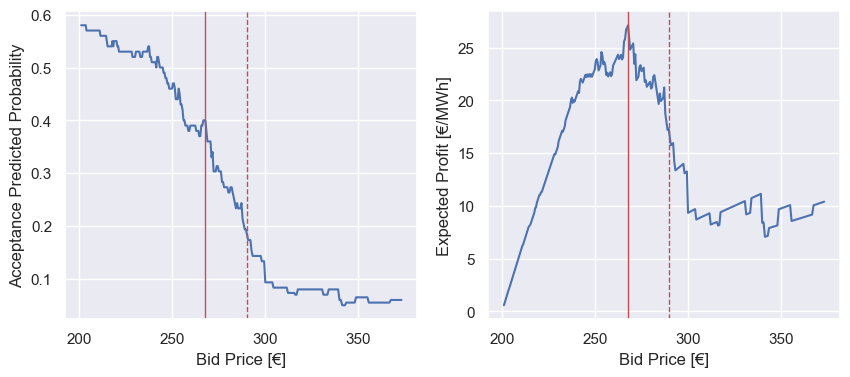

In [36]:
year = 2022
month = 1
tech = 'Fossil Gas'
marginal_cost = 200
n_prices = 300
random_state = 42

bid = df[(df.year == year)&(df.Tech == tech)&(df.month == month)].sample(1, random_state=random_state)

price_diff = np.linspace(0, 0.3, n_prices)
simulated_bids = pd.concat([bid] * n_prices, ignore_index=True)

simulated_bids['PriceDiff'] = price_diff
simulated_bids['Price'] = simulated_bids['MGPprice'] * (1 + simulated_bids['PriceDiff']) / (1 - simulated_bids['PriceDiff'])
simulated_bids['y_probs'] = predict_acc_prob(simulated_bids, clf)
simulated_bids['Expected Profit'] = (simulated_bids['Price'] - marginal_cost) * simulated_bids['y_probs']

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(simulated_bids['Price'], simulated_bids['y_probs'])
axs[1].plot(simulated_bids['Price'], simulated_bids['Expected Profit'])

axs[0].set_xlabel('Bid Price [€]')
axs[0].set_ylabel('Acceptance Predicted Probability')
# axs[0].set_title('Price vs. Predicted Probability')

axs[1].set_xlabel('Bid Price [€]')
axs[1].set_ylabel('Expected Profit [€/MWh]')
# axs[1].set_title('Price vs. Expected Profit')

for i in [0, 1]:
    axs[i].axvline(x=bid.Price.iloc[0], color='r', linestyle='--', linewidth=1) # Line for the actual bid price
    axs[i].axvline(x=simulated_bids.loc[simulated_bids['Expected Profit'].argmax(), 'Price'], color='r', linestyle='-', linewidth=1) # Line for the optimal bid price

bid

<HR>

# TESTS

In [18]:
simulated_bids.loc[simulated_bids['Expected Profit'].argmax(), 'Price']

267.7909516380655

In [39]:
predict_acc_prob(bid, clf)[0]

0.05

In [17]:
df.PriceDiff.describe()

count    3.574411e+06
mean     3.521638e-01
std      2.170092e-01
min     -1.000000e+00
25%      2.000000e-01
50%      3.030000e-01
75%      4.560000e-01
max      1.000000e+00
Name: PriceDiff, dtype: float64

<Axes: >

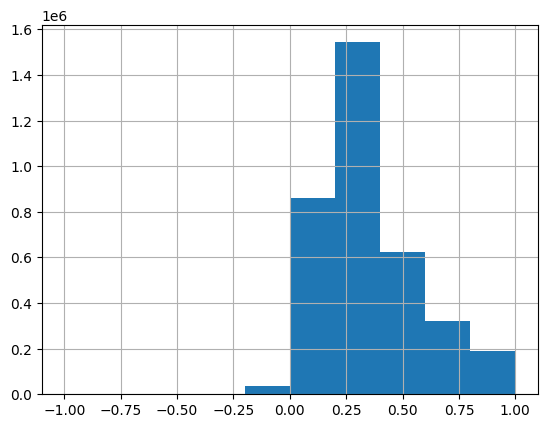

In [18]:
df.PriceDiff.hist()

In [13]:
df.sample(1)

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,DeclAngle,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,y_probs
2021092716UP_LA_CASELL_4_OFF,16,20210927,2021,UP_LA_CASELL_4,OFF,-0.037813,1.386071,3.605057,1.044494,1.057122,...,-2.618404,weekday,Piacenza,Fossil Gas,0.0,0.0,240.0,0.179,False,0.000209
